# Transfer learning

Das Ziel des Transferlearning ist es, ein bereits trainiertes Modell auf eine andere Aufgabe zu trainieren. Die Idee dahinter ist den Teil des Netzwerks, der für die Extraktion von Merkmalen zuständig ist, zu "recyceln". Da dies in der Regel der teuerste Teil des Trainings ist, spart man sich dadurch eine Menge an Zeit. Das bedeutet, dass dieser Teil nicht neu trainiert werden muss, sondern die bereits trainierte Featurextraktion genauso gut für eine ähnliche Aufgabe verwendet werden kann. Aus diesem Grund sollte man ein bereits trainiertes Netzwerk nutzen, welches für eine ähnliche Aufgabe trainiert wurde. Lediglich die Klassifikationsschicht wird neu trainiert. Ziel dieses Notebooks ist es, ein Verständnis zu bekommen, was beim Transferlearning passiert.

Schauen Sie sich folgendes Notebook an und versuchen Sie den groben Ablauf zu verstehen.
Sie werden die meisten Befehle die Sie benötigen darin finden.
https://www.tensorflow.org/tutorials/images/transfer_learning

Für diese Aufgabe wollen wir das in der letzten Aufgabe trainierte Convolutional Neural Network, welches auf dem Mnist Datensatz trainiert wurde, auf eine andere Aufgabe trainieren. Die Aufgabe des Netzwerks soll es sein, Hexadezimalzahlen zu erkennen.
Hierzu verwenden wir den $\textit{emnist}$ Datensatz. Dieser beinhaltet zusätzlich das Alphabet (große und kleine Buchstaben). Näheres dazu unter https://pypi.org/project/emnist/ 

Gehen Sie dazu wie folgt vor:

    * Laden Sie ihr Modell aus der vorherigen Aufgabe mit tf.keras.models.load_model("Name des Modells") Falls Sie ihr Modell nicht gespeichert hatten, können Sie dies mit model.save("Name des Modells"), nachdem Sie erneut trainiert haben, tun.
      
    * Bereiten Sie den emnist-Datensatz wie in der vorherigen Aufgabe vor und sortieren Sie alle Kleinbuchstaben sowie alle Buchstaben, die nicht der Hexadezimalschreibweise angehören, aus!
      
    * Laden Sie das zuvor gespeicherte Modell und entfernen Sie die letzte Schicht ( model.pop() )
    
    * Frieren Sie das Modell ein, d.h. Sie setzen die Layer auf nicht trainierbar
    
    * Fügen Sie eine neue Schicht hinzu, sodass die verschiedenen Klassen (0-F) klassifiziert werden können (Wir beschränken uns hier auf die groß geschriebenen Buchstaben)
    
    * Trainieren Sie das Netzwerk mit den transformierten Labels
    
    * Plotten Sie wieder die Trainingskurven und erstellen sie eine confusion Matrix

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix 
!pip install extra_keras_datasets
from extra_keras_datasets import emnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
# Vorbereiten von Nist

(input_train, target_train), (input_test, target_test) = emnist.load_data(type='balanced')

INFO:root:Loading dataset = emnist


In [72]:
# Sortieren Sie alle Ziffern aus, die unerwünscht sind!
# Hinweis: np.where ist hierfür recht Hilfreich

training_data = input_train[target_train < 16]
training_labels = target_train[target_train < 16]

test_data = input_test[target_test < 16]
test_labels = target_test[target_test < 16]

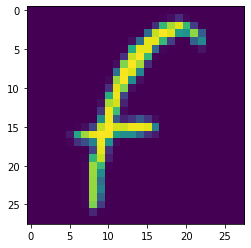

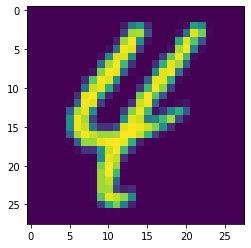

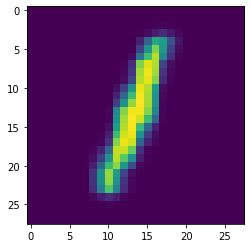

In [73]:
# Plotten Sie hier ein paar Ziffern!
for n in range(3):
  plt.imshow(training_data[n])
  plt.show()

In [74]:
# Normalisieren Sie das Set und bringen es in die richtige "shape"
training_data = np.reshape(training_data, (training_data.shape[0],28,28,1))
training_labels = tf.keras.utils.to_categorical(training_labels, num_classes=16)
test_data = np.reshape(test_data, (test_data.shape[0],28,28,1))
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=16)

print(training_data.shape)
print(training_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(38400, 28, 28, 1)
(38400, 16)
(6400, 28, 28, 1)
(6400, 16)


In [75]:
# Laden des Modells
base_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/mnist_model_internet/mnist_model")

#Hier die letzte Schicht entfernen
base_model.pop()
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 32)        25600     
                                                                 
 batch_normalization_10 (Bat  (None, 20, 20, 32)       128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 20, 20, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 10, 10, 32)       

In [76]:

# Modell einfrieren
base_model.trainable = False

# Basismodell als Ausgangspunkt nehmen
inputs = tf.keras.Input(shape=(28, 28,1))
x = base_model(inputs, training=False)

# Hier einen Dense-layer und einmal Softmax hinzufügen, sodass die verschiedenen Klassen vorhergesagt werden! können!
last_layer = tf.keras.layers.Dense(16)(x)
output     = tf.keras.layers.Activation('softmax')(last_layer)

# Modell Zusammenfügen
model = tf.keras.Model(inputs, output)

In [77]:
# Modell Kompilieren, Kostenfunktion categorical_crossentropy, Optimizer Adam mit der learningrate 1e-4

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_3 (Sequential)   (None, 84)                275024    
                                                                 
 dense_3 (Dense)             (None, 16)                1360      
                                                                 
 activation_3 (Activation)   (None, 16)                0         
                                                                 
Total params: 276,384
Trainable params: 1,360
Non-trainable params: 275,024
_________________________________________________________________


In [78]:
base_learning_rate = 0.00015
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Accuracy vor dem Transferlearning bestimmen
loss0, accuracy0 = model.evaluate(x = test_data,y = test_labels)



#200/200 [==============================] - 2s 1ms/step - loss: 3.4005 - accuracy: 0.0924

200/200 [==============================] - 9s 43ms/step - loss: 36.2750 - accuracy: 0.0598


In [79]:
# Hier das Netzwerk für 10 Epochen trainieren!
history = model.fit(training_data, training_labels,
                    batch_size=128,
                    epochs=10,
                    validation_data=(test_data, test_labels))

Epoch 1/10
300/300 [==============================] - 32s 100ms/step - loss: 17.6593 - accuracy: 0.0572 - val_loss: 6.6144 - val_accuracy: 0.0717
Epoch 2/10
300/300 [==============================] - 29s 95ms/step - loss: 3.7491 - accuracy: 0.2134 - val_loss: 2.2371 - val_accuracy: 0.3491
Epoch 3/10
300/300 [==============================] - 28s 94ms/step - loss: 1.6618 - accuracy: 0.4160 - val_loss: 1.2609 - val_accuracy: 0.4925
Epoch 4/10
300/300 [==============================] - 29s 98ms/step - loss: 1.0226 - accuracy: 0.5378 - val_loss: 0.8732 - val_accuracy: 0.5816
Epoch 5/10
300/300 [==============================] - 28s 94ms/step - loss: 0.7726 - accuracy: 0.6117 - val_loss: 0.7142 - val_accuracy: 0.6353
Epoch 6/10
300/300 [==============================] - 28s 94ms/step - loss: 0.6509 - accuracy: 0.6551 - val_loss: 0.6168 - val_accuracy: 0.6703
Epoch 7/10
300/300 [==============================] - 28s 94ms/step - loss: 0.5691 - accuracy: 0.6840 - val_loss: 0.5452 - val_accurac

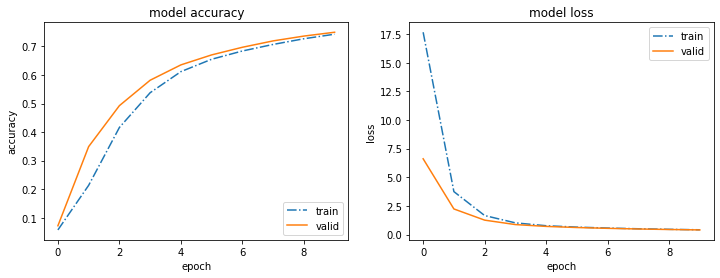

In [80]:
# Plotten der Trainingskurve wie in der Aufgabe zuvor
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [81]:
# Confusion Matrix erstellen
pred=model.predict(test_data)
print(confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(test_labels,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

[[251   3   3   2   0   0   3   8   0   0   0   3  47  79   1   0]
 [  0 321   0   1   3   0   3   5   5   0   9  36   4   2  10   1]
 [  1   2 359   1   1   0   0   0   0   0  11   0  21   0   4   0]
 [  0   1   1 380   0   2   0   6   0   0   0   9   1   0   0   0]
 [  0   1   1   0 333   4   0   2   1  10  24   1   0  14   0   9]
 [  0   1   1   5   0 357   0   0  10   0   9   2   0   1   8   6]
 [  0   2   0   0   0   0 383   0   0   0   1   2   1   0   6   5]
 [  2   3   5   2   3   2   1 340   2   4   2   2  12  16   0   4]
 [  0   4   0   0   0   0   0   1 333   4   8  36   0   2   2  10]
 [  2   0   0   0   2   0   0  14   2 348   7   7   0   4   1  13]
 [  0  13   5   1  42   2   1   3   9  30 234  32   1   6   7  14]
 [  1   4   0  12   0   2   2   2  28   8   9 317   8   3   3   1]
 [ 17   2  30   1   4   1   6   4   3   0  14   6 232  26  52   2]
 [ 92  15   0   8   1   0   1  17   4   2   7  11  54 184   4   0]
 [  0   1  11   1   0  14   5   0  13   2   6   5  29   0 266 